## preprocessing

In [1]:
pip install pandas_ta

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import keras
import pandas_ta as ta

In [3]:
cac_df = pd.read_csv('/content/Cac_weekly.csv', sep = ',', header = 0)
cac_df['Date'] = pd.to_datetime(cac_df['Date'], format = '%Y-%m-%d')

cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Low'] = 7354.54
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'High'] = 7523.56
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Close'] = 7491.96
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-14'), 'Open'] = 7443.38

cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Low'] = 7197.40
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'High'] = 7493.38
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Close'] = 7319.18
cac_df.loc[cac_df['Date']==pd.to_datetime('2023-05-21'), 'Open'] = 7467.93

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()

#standardization of the prices
cac_df[['Close', 'Open', 'Low', 'High']] = scaler.fit_transform(cac_df[['Close', 'Open', 'Low', 'High']])
cac_df.loc[cac_df['Volume']>0, ['Volume']] = scaler2.fit_transform(cac_df.loc[cac_df['Volume']>0, ['Volume']])

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

##Prima architettura (che corrisponde alle 5a in IBM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            640       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_1 (Dropout)         (None, 10, 10)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             11        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/30
98/98 [==============================] - 7s 25ms/step - loss: 0.4750 - val_loss: 0.6836
Epoch 2/30
98/98 [==============================] - 2s 16ms/step - loss: 0.4696 - val_loss: 0.6278
Epoch 3/30
98/98 [==============================] - 1s 10ms/step - loss: 0.4677 - val_loss: 0.6220
Epoch 4/30
98/98 [==============================] - 1s 11ms/step - loss: 0.4699 - val_loss: 0.6852
Epoch 5/30
98/98 [==============================] - 1s 12ms/step - loss: 0.4672 - val_loss: 0.6366
Epoch 6/30
98/98 [==============================] - 1s 12ms/step - loss: 0.4659 - val_loss: 0.6766
Epoch 7/30
98/98 [==============================] - 1s 12ms/step - loss: 0.4667 - val_loss: 0.7277
Epoch 8/30
98/98 [==============================] - 1s 12ms/step - loss: 0.4682 - val_loss: 0.6851
Epoch 9/30
98/98 [==============================] - 1s 12ms/step - loss: 0.4675 - val_loss: 0.6696
Epoch 10/30
98/98 [==============================] - 1s 14ms/step - loss: 0.4684 - val_loss: 0.7054
Epoch 11/

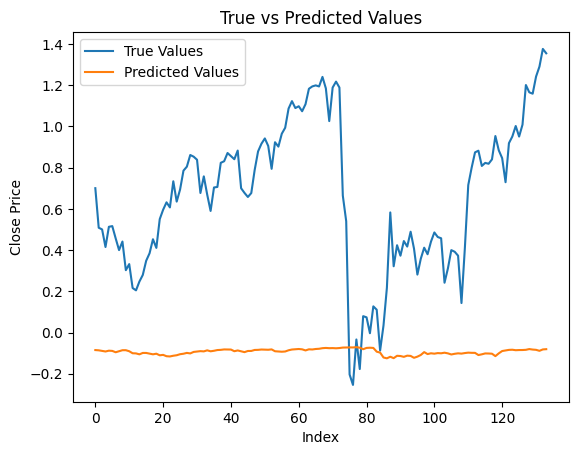

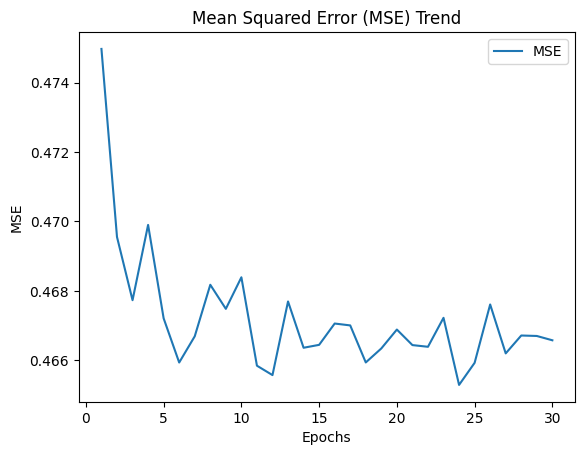

In [7]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=10,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=10,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


cac_df['RSI']=ta.rsi(cac_df.Close, length=10)
cac_df['EMAF']=ta.ema(cac_df.Close, length=20)
cac_df['EMAM']=ta.ema(cac_df.Close, length=100)
cac_df['EMAS']=ta.ema(cac_df.Close, length=150)

cac_df.dropna(inplace=True)
splitlimit = int(len(cac_df) * 0.8)
cac_df_train_set = cac_df.loc[:cac_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=cac_df_train_set.shape[0]

for x in range(cac_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(cac_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(cac_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(cac_df.index[0]+df_days, cac_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(cac_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(cac_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## SECONDA ARCHITETTURA: corrisponde alla 4a in ibm circa. Molti più layer, indicatori fissi, 15 epochs, finestra molto piccola: 3 settimane

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 3, 50)             0         
                                                                 
 dropout_2 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_3 (Dropout)         (None, 3, 50)             0

None

Epoch 1/15
99/99 [==============================] - 28s 38ms/step - loss: 0.4817 - val_loss: 0.7532
Epoch 2/15
99/99 [==============================] - 1s 15ms/step - loss: 0.4791 - val_loss: 0.7489
Epoch 3/15
99/99 [==============================] - 2s 16ms/step - loss: 0.4761 - val_loss: 0.7516
Epoch 4/15
99/99 [==============================] - 2s 17ms/step - loss: 0.4759 - val_loss: 0.7554
Epoch 5/15
99/99 [==============================] - 2s 25ms/step - loss: 0.4751 - val_loss: 0.7967
Epoch 6/15
99/99 [==============================] - 1s 15ms/step - loss: 0.4744 - val_loss: 0.6855
Epoch 7/15
99/99 [==============================] - 1s 14ms/step - loss: 0.4743 - val_loss: 0.8363
Epoch 8/15
99/99 [==============================] - 1s 14ms/step - loss: 0.4759 - val_loss: 0.7178
Epoch 9/15
99/99 [==============================] - 1s 14ms/step - loss: 0.4739 - val_loss: 0.7382
Epoch 10/15
99/99 [==============================] - 2s 16ms/step - loss: 0.4736 - val_loss: 0.7121
Epoch 11

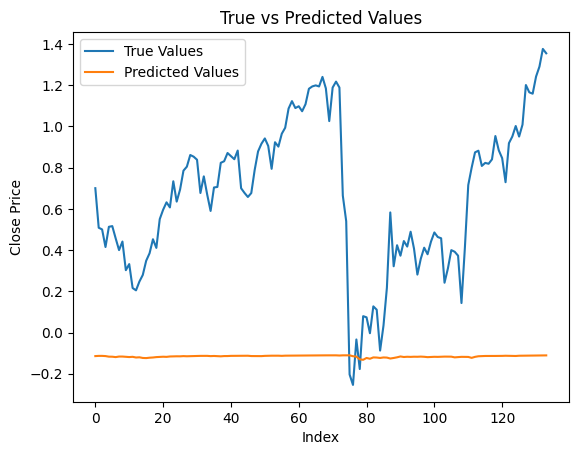

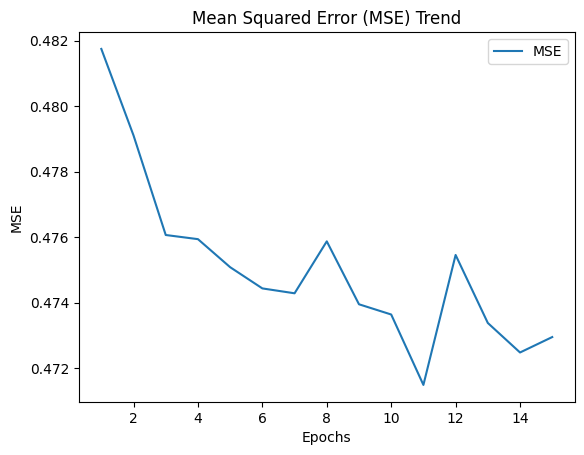

In [5]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


cac_df['RSI']=ta.rsi(cac_df.Close, length=10)
cac_df['EMAF']=ta.ema(cac_df.Close, length=20)
cac_df['EMAM']=ta.ema(cac_df.Close, length=100)
cac_df['EMAS']=ta.ema(cac_df.Close, length=150)

cac_df.dropna(inplace=True)
splitlimit = int(len(cac_df) * 0.8)
ibm_df_train_set = cac_df.loc[:cac_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(cac_df.index[0]+3, df_days):
  X_train.append(cac_df.loc[x-3:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(cac_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(cac_df.index[0]+df_days, cac_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(cac_df.loc[x-3:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(cac_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')


#training
history = model.fit(X_train, y_train,epochs=15, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#nota: qui si raggiunge un loss basso, ma il validation loss rimane ancora alto